In [1]:
pip install Keras-Preprocessing

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-08-31 13:21:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-31 13:21:24 (42.8 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [4]:
#Jumlah masuk data untuk diproses
BATCH_SIZE = 32

#Jumlah besar ukuran gambar
IMAGE_SIZE = (300, 300)

In [5]:
# dataset
dataset = "/kaggle/input/corn-or-maize-leaf-disease-dataset"
walk_through_dir(dataset);

There are 1 directories and 0 images in '/kaggle/input/corn-or-maize-leaf-disease-dataset'.
There are 4 directories and 0 images in '/kaggle/input/corn-or-maize-leaf-disease-dataset/data'.
There are 0 directories and 1306 images in '/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust'.
There are 0 directories and 1146 images in '/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Blight'.
There are 0 directories and 1162 images in '/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Healthy'.
There are 0 directories and 574 images in '/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Gray_Leaf_Spot'.


In [6]:
#letak file dan kategori
image_dir = Path(dataset)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Menggabungkan lokasi letak file dan kategori
image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
image_df

Filepath           Label
0     /kaggle/input/corn-or-maize-leaf-disease-datas...     Common_Rust
1     /kaggle/input/corn-or-maize-leaf-disease-datas...     Common_Rust
2     /kaggle/input/corn-or-maize-leaf-disease-datas...     Common_Rust
3     /kaggle/input/corn-or-maize-leaf-disease-datas...     Common_Rust
4     /kaggle/input/corn-or-maize-leaf-disease-datas...     Common_Rust
...                                                 ...             ...
4182  /kaggle/input/corn-or-maize-leaf-disease-datas...  Gray_Leaf_Spot
4183  /kaggle/input/corn-or-maize-leaf-disease-datas...  Gray_Leaf_Spot
4184  /kaggle/input/corn-or-maize-leaf-disease-datas...  Gray_Leaf_Spot
4185  /kaggle/input/corn-or-maize-leaf-disease-datas...  Gray_Leaf_Spot
4186  /kaggle/input/corn-or-maize-leaf-disease-datas...  Gray_Leaf_Spot

[4187 rows x 2 columns]

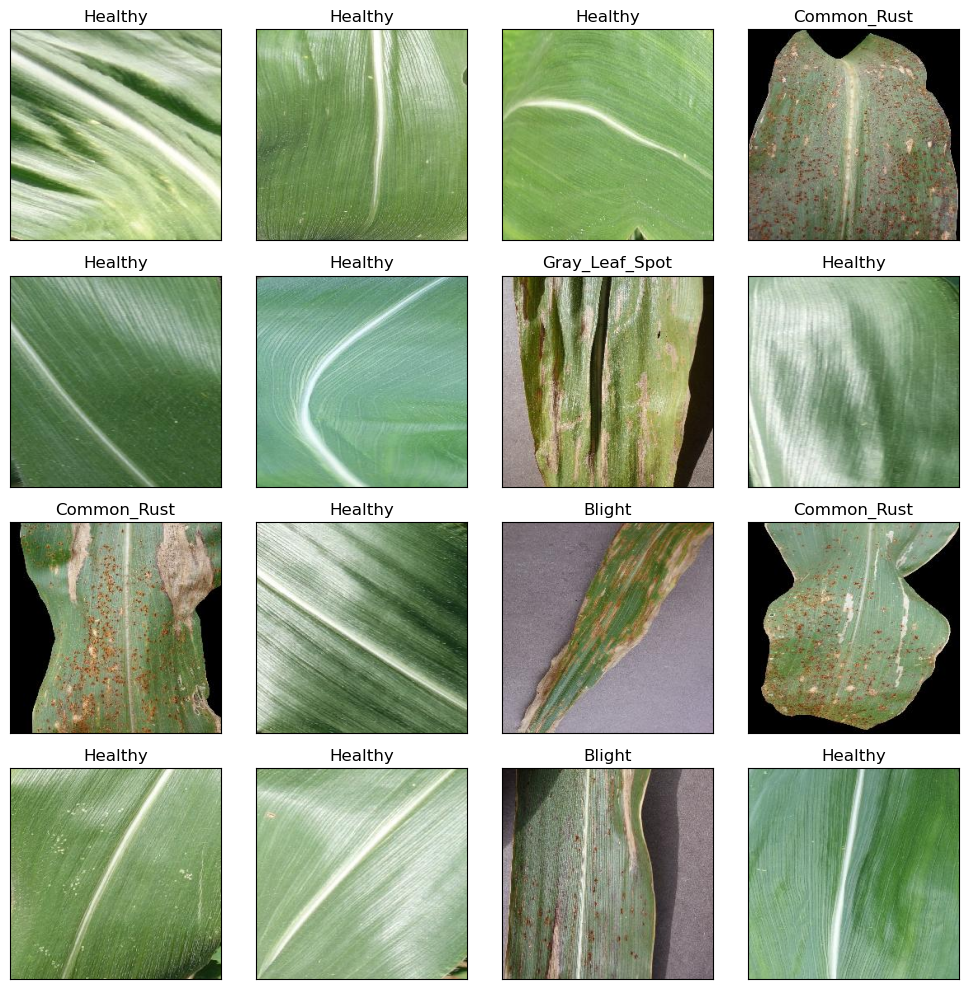

In [8]:
# Menampilkan foto random sesuai kategori
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
# pemisahan antara data train dan data test
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [10]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
# Membagi data menjadi beberapa kategori data (train, val dan test)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2680 validated image filenames belonging to 4 classes.
Found 669 validated image filenames belonging to 4 classes.
Found 838 validated image filenames belonging to 4 classes.


In [12]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [13]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [14]:
# Create checkpoint callback
checkpoint_path = "disease_classification"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [15]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", 
# watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) 
# if val loss decreases for 3 epochs in a row, stop training

In [16]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "disease_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/disease_classification/20240831-132137
Epoch 1/50
84/84 [==============================] - 91s 1s/step - loss: 0.6715 - accuracy: 0.7422 - val_loss: 0.3311 - val_accuracy: 0.8714
Epoch 2/50
84/84 [==============================] - 82s 980ms/step - loss: 0.3077 - accuracy: 0.8780 - val_loss: 0.2661 - val_accuracy: 0.8999
Epoch 3/50
84/84 [==============================] - 83s 983ms/step - loss: 0.2384 - accuracy: 0.9097 - val_loss: 0.2407 - val_accuracy: 0.9148
Epoch 4/50
84/84 [==============================] - 87s 1s/step - loss: 0.2117 - accuracy: 0.9153 - val_loss: 0.2233 - val_accuracy: 0.9238
Epoch 5/50
84/84 [==============================] - 83s 986ms/step - loss: 0.1782 - accuracy: 0.9317 - val_loss: 0.2159 - val_accuracy: 0.9238
Epoch 6/50
84/84 [==============================] - 83s 992ms/step - loss: 0.1567 - accuracy: 0.9429 - val_loss: 0.2187 - val_accuracy: 0.9178
Epoch 7/50
84/84 [==============================] - 86s 1s/ste

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [18]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.20687
Test Accuracy: 91.77%


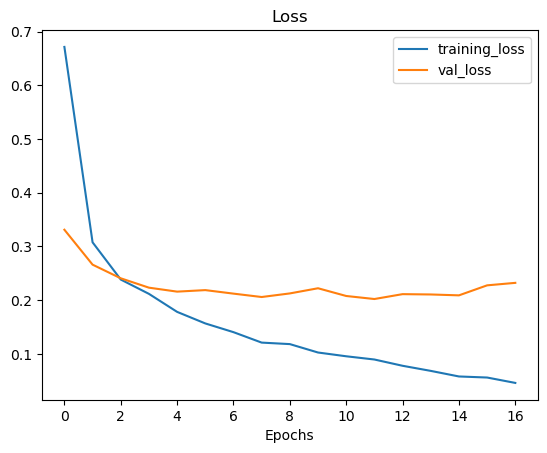

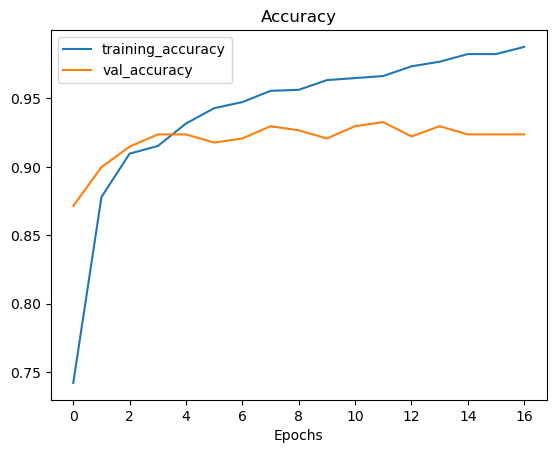

In [19]:
plot_loss_curves(history)

In [20]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 4 predictions: {pred[:10]}')

27/27 [==============================] - 21s 752ms/step
The first 4 predictions: ['Common_Rust', 'Gray_Leaf_Spot', 'Common_Rust', 'Common_Rust', 'Common_Rust', 'Common_Rust', 'Common_Rust', 'Common_Rust', 'Blight', 'Common_Rust']


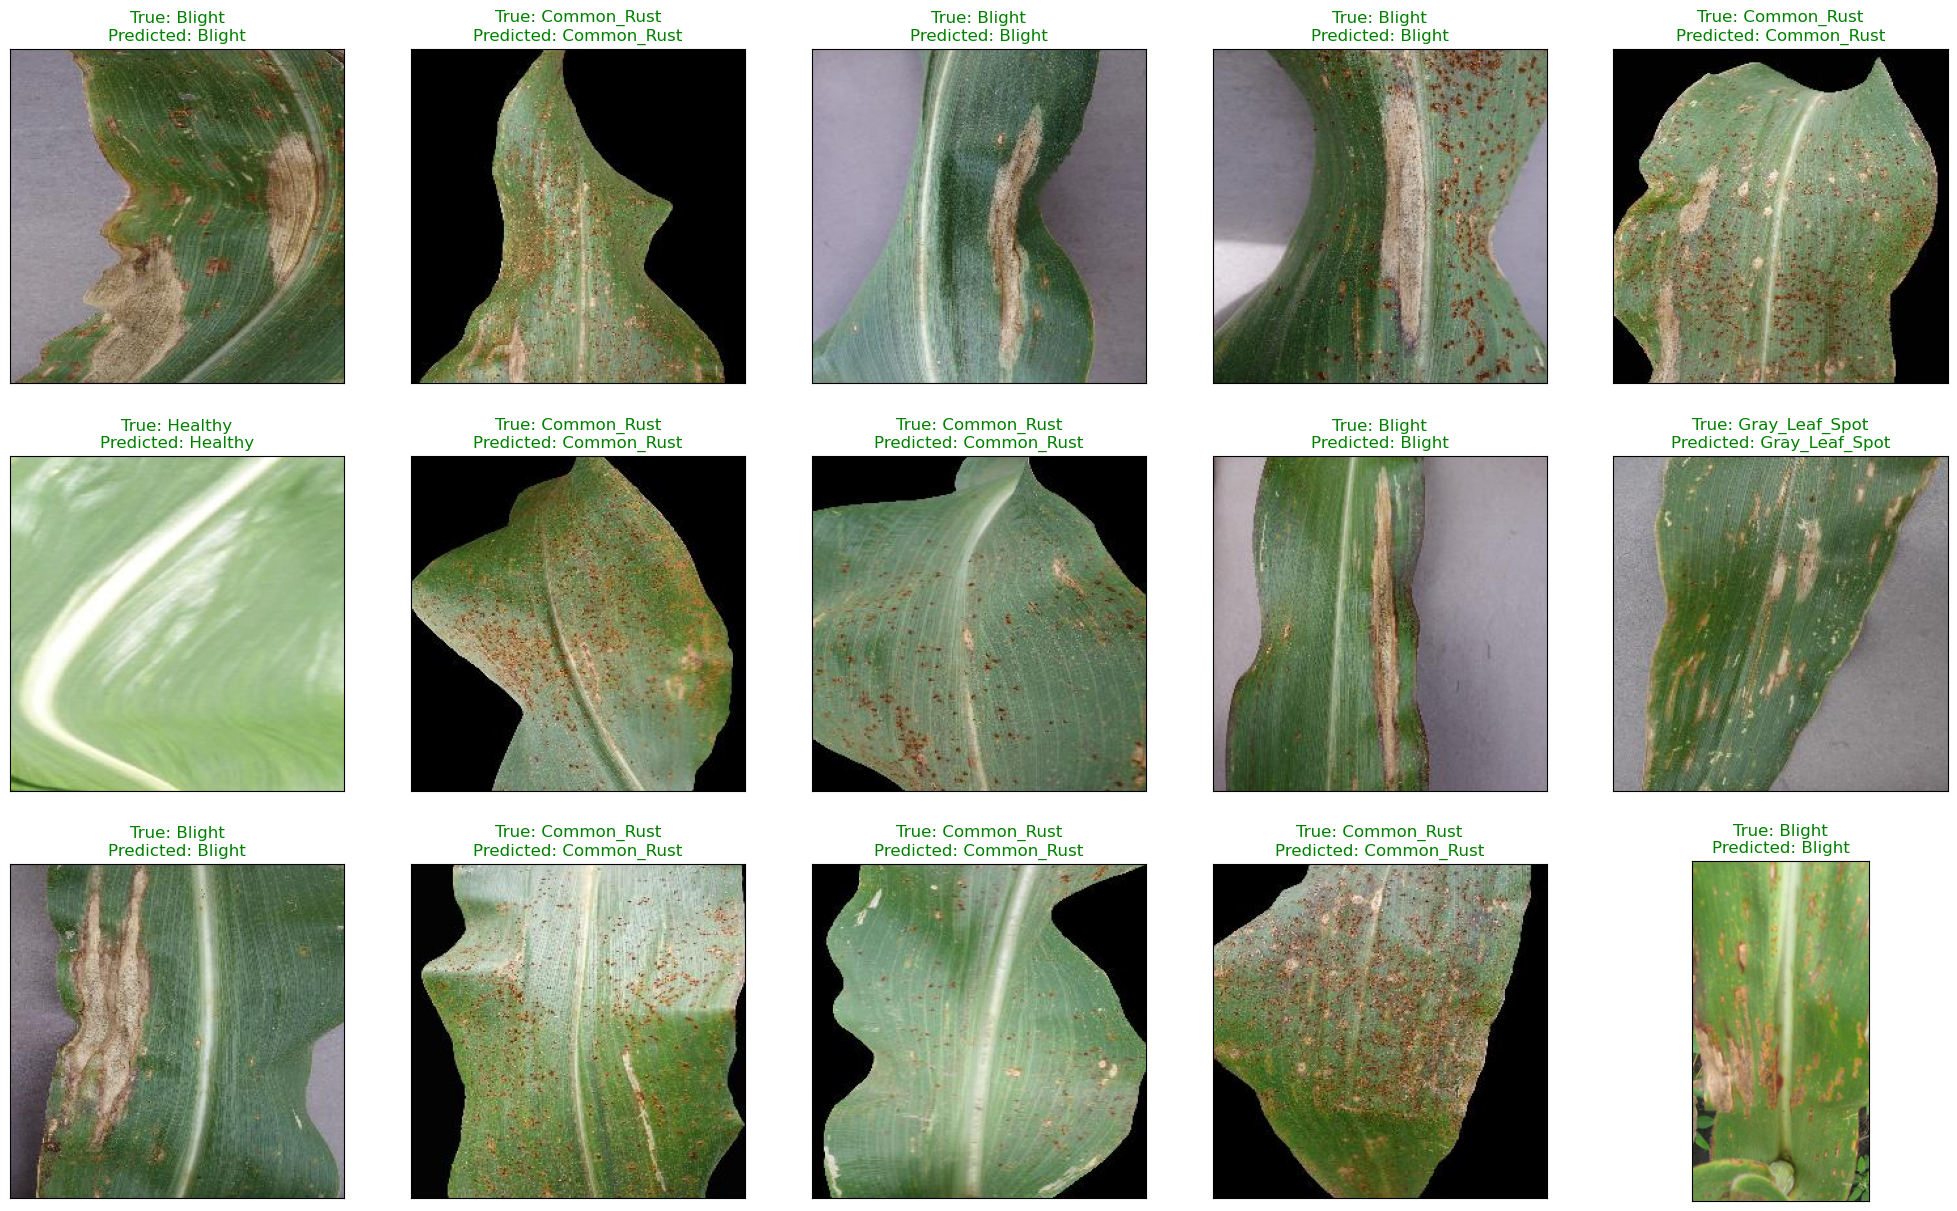

<Figure size 640x480 with 0 Axes>

In [21]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [22]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

        Blight       0.87      0.86      0.87       221
   Common_Rust       0.97      0.97      0.97       297
Gray_Leaf_Spot       0.72      0.76      0.74       108
       Healthy       1.00      0.99      0.99       212

      accuracy                           0.92       838
     macro avg       0.89      0.89      0.89       838
  weighted avg       0.92      0.92      0.92       838



In [23]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Blight           0.872146  0.864253  0.868182  221.000000
Common_Rust      0.969595  0.966330  0.967960  297.000000
Gray_Leaf_Spot   0.719298  0.759259  0.738739  108.000000
Healthy          1.000000  0.985849  0.992874  212.000000
accuracy         0.917661  0.917661  0.917661    0.917661
macro avg        0.890260  0.893923  0.891939  838.000000
weighted avg     0.919329  0.917661  0.918407  838.000000

In [24]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

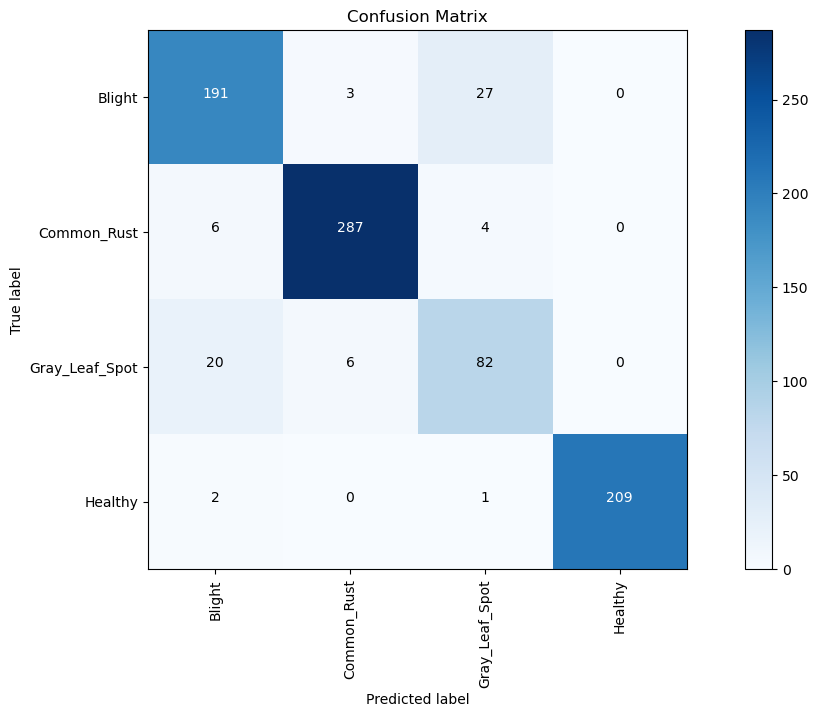

In [25]:
make_confusion_matrix(y_test, pred, list(labels.values()))